In [ ]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()
!pip install cloudpathlib[s3]
from cloudpathlib import CloudPath
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from time import strptime
import datetime
!pip install mac-vendor-lookup
from mac_vendor_lookup import MacLookup

In [ ]:
# !pip install pygle
# from pygle import network as wigleSearch

In [246]:
# Set Parameters
bucketFolderName = "ReportData"
localFolderName = "ReportData"
bucketName = "storagebucketname130605-dev/private/us-east-1:decaf162-e212-4ee2-96e4-adea45f7d0f6/"

In [ ]:
# Download data from bucket to local folder
cp = CloudPath("s3://" + bucketName + bucketFolderName + "/")
cp.download_to(localFolderName)

In [247]:
# Create DataFrame from all data in the folder
path = os.getcwd() + "/" + localFolderName
csv_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.read_csv(csv_files[0])
for f in csv_files[1:]:
    try:
        df1 = pd.read_csv(f)
        df = pd.concat([df, df1])
    except:
        print("Corrupted  file: " + f)

In [248]:
df.head()

,SSID,Capabilities,BSSID,Level,Timestamp,Venue Name,ScanTime
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,-62,40 days,NaN,Mon Mar 28 09:52:40 GMT+03:00 2022
1,TechPublic,[ESS],cc:d0:83:98:a6:40,-63,40 days,NaN,Mon Mar 28 09:52:40 GMT+03:00 2022
2,eduroam,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:42,-64,40 days,NaN,Mon Mar 28 09:52:40 GMT+03:00 2022
3,TechSec,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:41,-64,40 days,NaN,Mon Mar 28 09:52:40 GMT+03:00 2022
4,ה-iPhone של אורן,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],26:b7:5e:30:7f:be,-66,40 days,NaN,Mon Mar 28 09:52:40 GMT+03:00 2022


In [249]:
# df.drop(['Capabilities.1', 'BSSID.1', 'Level.1', 'Timestamp.1', 'Venue Name.1', 'ScanTimeSSID'], axis=1, inplace=True)
# df.head()

In [250]:
df.shape

(2540, 7)

In [251]:
# Drop uninteresting columns
df.drop(['Level', 'Timestamp', 'Venue Name'], axis=1, inplace=True)
# Drop uninteresting rows
df.drop(df[(df['Capabilities'] == '[IBSS]')].index, inplace=True)
df.drop_duplicates(subset=["BSSID", "ScanTime"], inplace=True)

In [252]:
df.shape

(2369, 4)

In [253]:
def openNetwork(r):
    return r['Capabilities'].count('[') <= 1

def WPA2only(r):
    return 'WPA2' in r['Capabilities'] and 'WPA-' not in r['Capabilities']

def WPA(r):
    if 'WPA2' in r['Capabilities'] and 'WPA-' not in r['Capabilities']:
        return False
    elif 'WPA' in r['Capabilities']:
        return True
    return False

def securityLevel(r):
    if r['Open']:
        return 0
    # Not Open
    if r['WPA']:
        return 1
    # Not Open & Not WPA
    if r['WPA2 Only']:
        return 3
    # Not Open & Not WPA & Not WPA2
    return 2

def securityAmount(r):
    return r['Capabilities'].count('[') - 1

In [254]:
# Analysis of the Capabilities column
df['Open'] = df.apply(lambda row: openNetwork(row), axis=1)

df['WPA2 Only'] = df.apply(lambda row: WPA2only(row), axis=1)

df['WPA'] = df.apply(lambda row: WPA(row), axis=1)

df['Security Level'] = df.apply(lambda row: securityLevel(row), axis=1)

df['Security Amount'] = df.apply(lambda row: securityAmount(row), axis=1)

In [255]:
df.head(2)

,SSID,Capabilities,BSSID,ScanTime,Open,WPA2 Only,WPA,Security Level,Security Amount
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,Mon Mar 28 09:52:40 GMT+03:00 2022,False,True,False,3,2
1,TechPublic,[ESS],cc:d0:83:98:a6:40,Mon Mar 28 09:52:40 GMT+03:00 2022,True,False,False,0,0


In [256]:
df['Security Level'].value_counts()

3    1668
0     378
2     248
1      75
Name: Security Level, dtype: int64

In [257]:
df[df["Security Level"] == 2]["Capabilities"].value_counts()

[RSN-OWE_TRANSITION-CCMP][ESS]                  170
[RSN-OWE-CCMP][RSN-OWE_TRANSITION-CCMP][ESS]     78
Name: Capabilities, dtype: int64

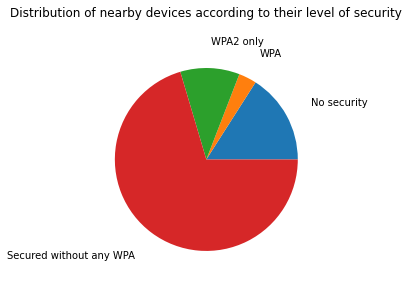

In [258]:
y = df['Security Level'].value_counts().sort_index()
labels = ["No security","WPA","WPA2 only","Secured without any WPA"]
plt.pie(y, labels= labels, labeldistance= 1.3)
# plt.legend(labels= labels, bbox_to_anchor= (1, 1), loc= 'upper left')
plt.title("Distribution of nearby devices according to their level of security", y=1.1)
plt.tight_layout()
plt.show() 

In [259]:
df['Security Amount'].value_counts()

2    1719
0     378
1     170
3      88
4      14
Name: Security Amount, dtype: int64

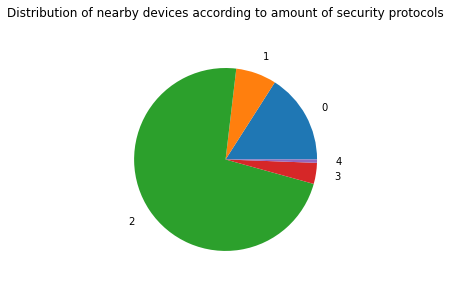

In [260]:
y = df['Security Amount'].value_counts().sort_index()
labels = y.index.tolist()
plt.pie(y,labels= labels, labeldistance= 1.2)
plt.title("Distribution of nearby devices according to amount of security protocols", y=1.1)
plt.tight_layout()
plt.show() 

In [261]:
scanCount = df["ScanTime"].nunique()
scanCount

172

In [262]:
df["SSID"].nunique()

29

In [263]:
df["SSID"].value_counts(dropna=False)

TechSec                         355
eduroam                         328
TechPublic                      327
CS_GUEST                        221
CS_WIFI                         218
lib-test                        204
students_WIFI                   200
CS_conference                   184
NaN                             134
Aseel                            31
Bonie                            29
HOTBOX 4-62D8                    19
DIRECT-99-HP PageWide P55250     18
ה-iPhone של אורן                 18
CRL                              14
459-02                           14
sonos_gar                        13
WIFI_SSDL                        11
DIRECT-gBDESKTOP-RQ05JV4ms7F      6
 ל                                5
BenarriMay’s phone                5
RotemPhone                        5
CIS                               2
COFFEES                           2
AndroidAP48FC                     1
CRL_ROBOTS                        1
nahum                             1
POCO F3                     

In [264]:
appearances = df.groupby(["BSSID"]).size().reset_index(name="scanCount")
appearances

,BSSID,scanCount
0,00:21:e1:cf:6e:00,2
1,00:21:e1:cf:6e:02,1
2,00:21:e1:cf:6e:04,2
3,02:b5:d0:2d:16:f9,31
4,0a:c5:e1:b9:48:fc,1
...,...,...
195,d0:15:a6:74:22:e0,1
196,d0:15:a6:74:22:e1,1
197,d0:15:a6:74:22:e2,1
198,d6:d2:52:d8:b5:ad,6


In [265]:
appearances2 = df.groupby(["SSID"]).size().reset_index(name="scanCount")
appearances2.head(2)

,SSID,scanCount
0,ל,5
1,459-02,14


In [266]:
max_scanCount = appearances["scanCount"].max()
min_scanCount = appearances["scanCount"].min()
print("max scanCount = {}".format(max_scanCount))
print("min scanCount = {}".format(min_scanCount))
# appearances["scanCount"].value_counts().sort_index(ascending=True)

max scanCount = 80
min scanCount = 1


In [267]:
max_scanCount2 = appearances2["scanCount"].max()
min_scanCount2 = appearances2["scanCount"].min()
print("max scanCount = {}".format(max_scanCount2))
print("min scanCount = {}".format(min_scanCount2))
# appearances["scanCount"].value_counts().sort_index(ascending=True)

max scanCount = 355
min scanCount = 1


In [268]:
def BSSIDpresenceDensity(r):
    rScanCount = appearances[appearances.BSSID == r.BSSID].values[0][1] # values[0][1] == scanCount value
    rScanCountScaled = (rScanCount - min_scanCount) / (max_scanCount - min_scanCount)
    
    if rScanCountScaled >= 0.8:
        return 'persistent'
    if rScanCountScaled >= 0.3:
        return 'occasional'
    return 'rare'

def SSIDpresenceDensity(r):
    rScanCountScaled = (r.scanCount - min_scanCount2) / (max_scanCount2 - min_scanCount2)
    
    if rScanCountScaled >= 0.8:
        return 'persistent'
    if rScanCountScaled >= 0.3:
        return 'occasional'
    return 'rare'

In [269]:
df['BSSID Presence Density'] = df.apply(lambda row: BSSIDpresenceDensity(row), axis=1)
appearances2['SSID Presence Density'] = appearances2.apply(lambda row: SSIDpresenceDensity(row), axis=1)

In [270]:
df.head(4)

,SSID,Capabilities,BSSID,ScanTime,Open,WPA2 Only,WPA,Security Level,Security Amount,BSSID Presence Density
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,Mon Mar 28 09:52:40 GMT+03:00 2022,False,True,False,3,2,occasional
1,TechPublic,[ESS],cc:d0:83:98:a6:40,Mon Mar 28 09:52:40 GMT+03:00 2022,True,False,False,0,0,persistent
2,eduroam,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:42,Mon Mar 28 09:52:40 GMT+03:00 2022,False,True,False,3,2,persistent
3,TechSec,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:41,Mon Mar 28 09:52:40 GMT+03:00 2022,False,True,False,3,2,persistent


In [271]:
appearances2['SSID Presence Density'].value_counts()

rare          21
occasional     5
persistent     3
Name: SSID Presence Density, dtype: int64

In [272]:
appearances2.head(4)

,SSID,scanCount,SSID Presence Density
0,ל,5,rare
1,459-02,14,rare
2,AndroidAP48FC,1,rare
3,Aseel,31,rare


In [273]:
appearances2[appearances2['SSID Presence Density']=='persistent'].head()

,SSID,scanCount,SSID Presence Density
20,TechPublic,327,persistent
21,TechSec,355,persistent
23,eduroam,328,persistent


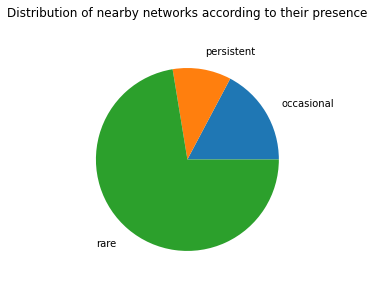

In [274]:
y = appearances2['SSID Presence Density'].value_counts().sort_index()
labels = y.index.tolist()
plt.pie(y,labels= labels, labeldistance= 1.2)
plt.title("Distribution of nearby networks according to their presence", y=1.1)
plt.tight_layout()
plt.show() 

In [275]:
df1 = df.drop_duplicates(subset=["BSSID", "BSSID Presence Density"])
df1['BSSID Presence Density'].value_counts()

rare          168
occasional     29
persistent      3
Name: BSSID Presence Density, dtype: int64

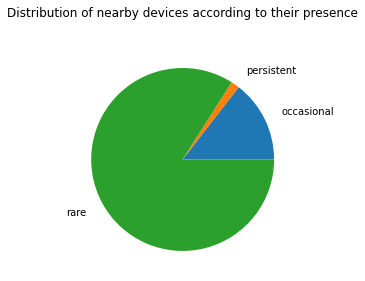

In [276]:
y = df1['BSSID Presence Density'].value_counts().sort_index()
labels = y.index.tolist()
plt.pie(y,labels= labels, labeldistance= 1.2)
plt.title("Distribution of nearby devices according to their presence", y=1.1)
plt.tight_layout()
plt.show() 

In [277]:
StationsPerNetwork = df1.groupby("SSID")['BSSID'].value_counts()
print(StationsPerNetwork.to_string())

SSID                          BSSID            
 ל                            56:2e:24:48:d4:45    1
459-02                        68:ff:7b:c8:4f:15    1
                              78:65:59:6e:25:16    1
AndroidAP48FC                 0a:c5:e1:b9:48:fc    1
Aseel                         02:b5:d0:2d:16:f9    1
BenarriMay’s phone            4a:61:10:34:a9:40    1
Bonie                         a8:6a:bb:cd:d7:76    1
CIS                           48:4a:e9:1a:0e:c3    1
COFFEES                       14:ae:db:b1:6e:a5    1
CRL                           0c:80:63:7b:d9:cb    1
CRL_ROBOTS                    48:4a:e9:1a:0e:c0    1
CS_GUEST                      48:4a:e9:18:ab:08    1
                              48:4a:e9:18:c3:25    1
                              48:4a:e9:19:75:e5    1
                              48:4a:e9:1a:c2:25    1
                              48:4a:e9:1b:28:25    1
                              48:4a:e9:1b:a9:a5    1
                              48:4a:e9:1b:ae:e8    

In [278]:
StationsPerNetwork = df.drop_duplicates(subset=["SSID","BSSID"])
StationsPerNetwork = StationsPerNetwork.groupby(["SSID"]).size().reset_index(name="Stations Count")
StationsPerNetwork.head(12)

,SSID,Stations Count
0,ל,1
1,459-02,2
2,AndroidAP48FC,1
3,Aseel,1
4,BenarriMay’s phone,1
5,Bonie,1
6,CIS,1
7,COFFEES,1
8,CRL,1
9,CRL_ROBOTS,1


In [279]:
StPerNet = StationsPerNetwork['Stations Count'].value_counts().rename_axis('Stations Count').reset_index(name='Networks Count')
StPerNet.sort_values(by=['Stations Count'], inplace=True)
StPerNet

,Stations Count,Networks Count
0,1,18
1,2,3
4,13,1
3,15,1
2,18,3
5,24,1
7,27,1
6,28,1


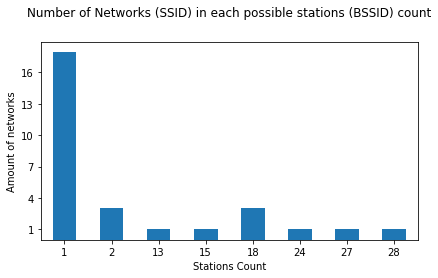

In [280]:
StPerNet.plot.bar(x='Stations Count', y='Networks Count', rot=0, legend=None)
plt.yticks(np.arange(StPerNet["Networks Count"].min(), StPerNet["Networks Count"].max()+1,3))
plt.ylabel('Amount of networks')
plt.title("Number of Networks (SSID) in each possible stations (BSSID) count", y=1.1)
plt.tight_layout()
plt.show() 

In [281]:
df.dtypes

SSID                      object
Capabilities              object
BSSID                     object
ScanTime                  object
Open                        bool
WPA2 Only                   bool
WPA                         bool
Security Level             int64
Security Amount            int64
BSSID Presence Density    object
dtype: object

In [282]:
df = df.astype({"ScanTime": str})

In [283]:
def changeScanTimeType(r):
    # [Day, Month, Date, hh:mm:ss, GMT, Year]
    try:
        if pd.isna(r['ScanTime']):
            return np.nan
        old = r['ScanTime'].split() 
        month = int(strptime(old[1], '%b').tm_mon)
        oldTime = old[3].split(":")
        oldTime = list(map(int, oldTime))
        newScanTime = datetime.datetime(int(old[5]), month, int(old[2]), oldTime[0], oldTime[1], oldTime[2])
        return newScanTime
    except:
        return np.nan

In [284]:
df['Scan Time'] = df.apply(lambda row: changeScanTimeType(row), axis=1)
df.drop(['ScanTime'], axis=1, inplace=True)

In [285]:
df.head(4)

,SSID,Capabilities,BSSID,Open,WPA2 Only,WPA,Security Level,Security Amount,BSSID Presence Density,Scan Time
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,False,True,False,3,2,occasional,2022-03-28 09:52:40
1,TechPublic,[ESS],cc:d0:83:98:a6:40,True,False,False,0,0,persistent,2022-03-28 09:52:40
2,eduroam,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:42,False,True,False,3,2,persistent,2022-03-28 09:52:40
3,TechSec,[WPA2-EAP+FT/EAP-CCMP][RSN-EAP+FT/EAP-CCMP][ESS],cc:d0:83:98:a6:41,False,True,False,3,2,persistent,2022-03-28 09:52:40


In [286]:
ScanTimes = df.groupby(["BSSID"]).agg(
        minScanTime=('Scan Time', 'min'),
        maxScanTime=('Scan Time', 'max')).reset_index(['BSSID'])
ScanTimes

,BSSID,minScanTime,maxScanTime
0,00:21:e1:cf:6e:00,2022-03-29 13:02:18,2022-03-29 13:05:43
1,00:21:e1:cf:6e:02,2022-03-29 13:05:43,2022-03-29 13:05:43
2,00:21:e1:cf:6e:04,2022-03-29 12:58:41,2022-03-29 13:05:43
3,02:b5:d0:2d:16:f9,2022-03-28 10:37:41,2022-03-28 13:23:38
4,0a:c5:e1:b9:48:fc,2022-03-29 11:35:43,2022-03-29 11:35:43
...,...,...,...
195,d0:15:a6:74:22:e0,2022-03-29 13:28:11,2022-03-29 13:28:11
196,d0:15:a6:74:22:e1,2022-03-29 13:28:11,2022-03-29 13:28:11
197,d0:15:a6:74:22:e2,2022-03-29 13:28:11,2022-03-29 13:28:11
198,d6:d2:52:d8:b5:ad,2022-03-28 11:41:37,2022-03-28 12:26:38


In [287]:
ScanTimes2 = df.groupby(["SSID"]).agg(
        minScanTime=('Scan Time', 'min'),
        maxScanTime=('Scan Time', 'max')).reset_index(['SSID'])
ScanTimes2.head()

,SSID,minScanTime,maxScanTime
0,ל,2022-03-29 12:05:44,2022-03-29 12:09:10
1,459-02,2022-03-28 14:52:45,2022-03-29 14:47:03
2,AndroidAP48FC,2022-03-29 11:35:43,2022-03-29 11:35:43
3,Aseel,2022-03-28 10:37:41,2022-03-28 13:23:38
4,BenarriMay’s phone,2022-03-29 11:20:41,2022-03-29 11:24:10


In [288]:
def calcLifetime(r):
    rMinScanTime = ScanTimes[ScanTimes.BSSID == r.BSSID].values[0][1] # values[0][1] == minScanTime
    rMaxScanTime = ScanTimes[ScanTimes.BSSID == r.BSSID].values[0][2] # values[0][2] == maxScanTime
    diff = rMaxScanTime - rMinScanTime
    
    return round(diff.seconds / 3600, 2) + diff.days * 24

def SSIDcalcLifetime(r):
    diff = r.maxScanTime - r.minScanTime
    
    return round(diff.seconds / 3600, 2) + diff.days * 24

In [289]:
df['Lifetime'] = df.apply(lambda row: calcLifetime(row), axis=1)

In [290]:
ScanTimes2['SSID Lifetime'] = ScanTimes2.apply(lambda row: SSIDcalcLifetime(row), axis=1)
ScanTimes2.head(4)

,SSID,minScanTime,maxScanTime,SSID Lifetime
0,ל,2022-03-29 12:05:44,2022-03-29 12:09:10,0.06
1,459-02,2022-03-28 14:52:45,2022-03-29 14:47:03,23.91
2,AndroidAP48FC,2022-03-29 11:35:43,2022-03-29 11:35:43,0.00
3,Aseel,2022-03-28 10:37:41,2022-03-28 13:23:38,2.77


In [291]:
max_Lifetime = ScanTimes2["SSID Lifetime"].max()
min_Lifetime = ScanTimes2["SSID Lifetime"].min()
print("max Lifetime = {}".format(max_Lifetime))
print("min Lifetime = {}".format(min_Lifetime))

max Lifetime = 27.72
min Lifetime = 0.0


In [292]:
def lifetimeNorm(r):
    return round((r["SSID Lifetime"] - min_Lifetime) / (max_Lifetime - min_Lifetime), 2)

In [293]:
ScanTimes2['Lifetime %'] = ScanTimes2.apply(lambda row: lifetimeNorm(row), axis=1)
ScanTimes2.head(30)

,SSID,minScanTime,maxScanTime,SSID Lifetime,Lifetime %
0,ל,2022-03-29 12:05:44,2022-03-29 12:09:10,0.06,0.00
1,459-02,2022-03-28 14:52:45,2022-03-29 14:47:03,23.91,0.86
2,AndroidAP48FC,2022-03-29 11:35:43,2022-03-29 11:35:43,0.00,0.00
3,Aseel,2022-03-28 10:37:41,2022-03-28 13:23:38,2.77,0.10
4,BenarriMay’s phone,2022-03-29 11:20:41,2022-03-29 11:24:10,0.06,0.00
5,Bonie,2022-03-28 14:17:50,2022-03-29 14:47:03,24.49,0.88
6,CIS,2022-03-29 12:35:23,2022-03-29 13:02:18,0.45,0.02
7,COFFEES,2022-03-28 09:46:03,2022-03-28 09:47:59,0.03,0.00
8,CRL,2022-03-29 12:32:23,2022-03-29 13:08:43,0.61,0.02
9,CRL_ROBOTS,2022-03-29 13:05:43,2022-03-29 13:05:43,0.00,0.00


In [294]:
ScanTimes2['Lifetime %'].value_counts().sort_index(ascending=True)

0.00    9
0.02    4
0.03    1
0.08    1
0.09    2
0.10    6
0.86    1
0.88    2
1.00    3
Name: Lifetime %, dtype: int64

In [295]:
scanT_stationC = ScanTimes2.merge(StationsPerNetwork, on= 'SSID')
scanT_stationC.head()

,SSID,minScanTime,maxScanTime,SSID Lifetime,Lifetime %,Stations Count
0,ל,2022-03-29 12:05:44,2022-03-29 12:09:10,0.06,0.00,1
1,459-02,2022-03-28 14:52:45,2022-03-29 14:47:03,23.91,0.86,2
2,AndroidAP48FC,2022-03-29 11:35:43,2022-03-29 11:35:43,0.00,0.00,1
3,Aseel,2022-03-28 10:37:41,2022-03-28 13:23:38,2.77,0.10,1
4,BenarriMay’s phone,2022-03-29 11:20:41,2022-03-29 11:24:10,0.06,0.00,1


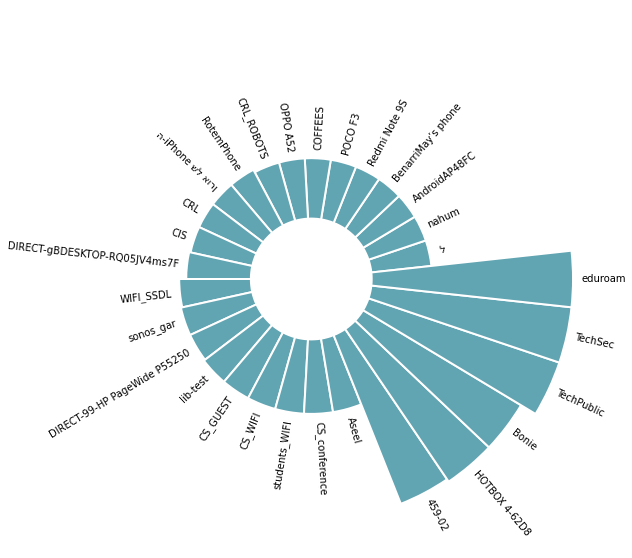

In [296]:
# Reorder the dataframe
ScanTimes2 = ScanTimes2.sort_values(by=['Lifetime %'])

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = ScanTimes2["Lifetime %"].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (upperLimit - lowerLimit) / max
heights = slope * ScanTimes2["Lifetime %"] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(ScanTimes2.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(ScanTimes2.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, ScanTimes2["SSID"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")

In [297]:
def vendor(r):
    try:
        return MacLookup().lookup(r['BSSID'])
    except:
        return np.nan
    
def enterprise(r):
    if pd.isna(r['Vendor']):
        return False
    return 'Enterprise' in r['Vendor']

In [298]:
df['Vendor'] = df.apply(lambda row: vendor(row), axis=1)

In [299]:
df.head(2)

,SSID,Capabilities,BSSID,Open,WPA2 Only,WPA,Security Level,Security Amount,BSSID Presence Density,Scan Time,Lifetime,Vendor
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,False,True,False,3,2,occasional,2022-03-28 09:52:40,3.69,VTech Telecommunications Ltd.
1,TechPublic,[ESS],cc:d0:83:98:a6:40,True,False,False,0,0,persistent,2022-03-28 09:52:40,3.69,"Aruba, a Hewlett Packard Enterprise Company"


In [300]:
# How many devices belong to each vendor? 
df1 = df.drop_duplicates(subset=["BSSID", "Vendor"])
df1['Vendor'].value_counts(dropna=False)

Hewlett Packard Enterprise                     158
Aruba, a Hewlett Packard Enterprise Company     19
NaN                                             12
Sagemcom Broadband SAS                           3
Nortel Networks                                  3
VTech Telecommunications Ltd.                    2
TP-LINK TECHNOLOGIES CO.,LTD.                    2
D-Link International                             1
Name: Vendor, dtype: int64

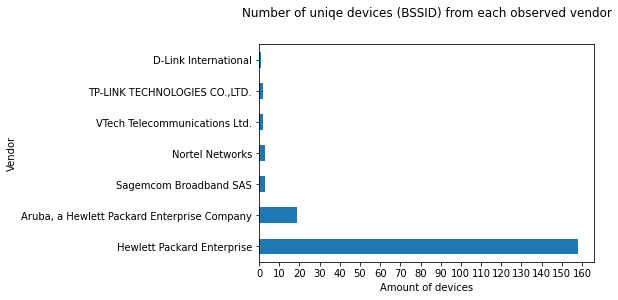

In [301]:
df1.Vendor.value_counts().plot(kind = 'barh')
plt.xticks(np.arange(0, df1['Vendor'].value_counts().max()+10,10))
plt.ylabel('Vendor')
plt.xlabel('Amount of devices')
plt.title("Number of uniqe devices (BSSID) from each observed vendor", y=1.1)
plt.show() 

In [302]:
df['Enterprise'] = df.apply(lambda row: enterprise(row), axis=1)

In [303]:
df.head(2)

,SSID,Capabilities,BSSID,Open,WPA2 Only,WPA,Security Level,Security Amount,BSSID Presence Density,Scan Time,Lifetime,Vendor,Enterprise
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,False,True,False,3,2,occasional,2022-03-28 09:52:40,3.69,VTech Telecommunications Ltd.,False
1,TechPublic,[ESS],cc:d0:83:98:a6:40,True,False,False,0,0,persistent,2022-03-28 09:52:40,3.69,"Aruba, a Hewlett Packard Enterprise Company",True


In [304]:
# How many devices (BSSID) are enterprise type? 
df1 = df.drop_duplicates(subset=["BSSID", "Enterprise"])
df1['Enterprise'].value_counts().sort_index()

False     23
True     177
Name: Enterprise, dtype: int64

In [305]:
# How many devices (BSSID) are enterprise type? 
df1 = df.drop_duplicates(subset=["BSSID", "Enterprise"])
df1['Enterprise'].value_counts(normalize= True).sort_index()

False    0.115
True     0.885
Name: Enterprise, dtype: float64

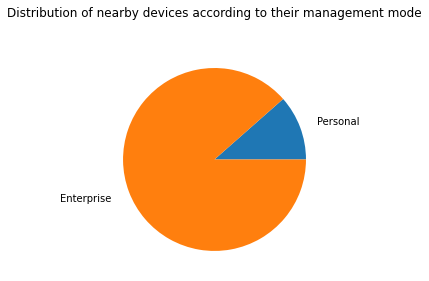

In [307]:
y = df1['Enterprise'].value_counts().sort_index()
labels = ["Personal","Enterprise"]
plt.pie(y,labels= labels, labeldistance= 1.2)
plt.title("Distribution of nearby devices according to their management mode", y=1.1)
plt.tight_layout()
plt.show()

In [308]:
# wigle_cache = {}

In [309]:
# wigle_cache

In [310]:
# def wigle(r):
#     if r.BSSID in wigle_cache:
#         return wigle_cache[r.BSSID]
#     try:
#         wigleSearch.detail(netid=r.BSSID)
#         wigle_cache[r.BSSID] = True
#         return True
#     except Exception as e:
#         if e.args[0][0:3] == '429':
#             return np.nan
#         wigle_cache[r.BSSID] = False
#         return False    

In [311]:
# df['Found on WiGLE'] = df.apply(lambda row: wigle(row), axis=1)

In [312]:
# df['Found on WiGLE'].value_counts()

In [313]:
# def BSSIDwigle(BSSID):
#     if BSSID in wigle_cache:
#         return wigle_cache[BSSID]
#     try:
#         wigleSearch.detail(netid=BSSID)
#         wigle_cache[BSSID] = True
#         return True
#     except Exception as e:
#         print(e)

In [314]:
# BSSIDwigle("14:ae:db:b1:7b:c5")

In [315]:
# try:
#     wigleSearch.detail(netid="48:4a:e9:18:ab:02")
#     print(True)
# except Exception as e:
#     print(e)

In [317]:
df.head(1)

,SSID,Capabilities,BSSID,Open,WPA2 Only,WPA,Security Level,Security Amount,BSSID Presence Density,Scan Time,Lifetime,Vendor,Enterprise
0,NaN,[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS],14:ae:db:b1:7b:c5,False,True,False,3,2,occasional,2022-03-28 09:52:40,3.69,VTech Telecommunications Ltd.,False


In [320]:
sec_amount_weight, sec_level_weight = 2/5, 3/5
Max_Sec_Amount = df['Security Amount'].max()
assert(Max_Sec_Amount != 0)
Max_Sec_Level = 3
max_LifetimeBSSID = df["Lifetime"].max()
min_LifetimeBSSID = df["Lifetime"].min()
max_StationsNumber = StationsPerNetwork["Stations Count"].max()
min_StationsNumber = StationsPerNetwork["Stations Count"].min()

w1,w2,w3,w4,w5 = 0.175, 0.175, 0.35, 0.2, 0.1

def RiskAssessment():
    # SSID Presence Grade
    rareRateSSID = appearances2['SSID Presence Density'].value_counts(normalize= True)['rare']
    SSID_Presence_Grade = 1 - rareRateSSID
    print("SSID_Presence_Grade = {}".format(SSID_Presence_Grade))
    
    # BSSID Presence Grade
    df1 = df.drop_duplicates(subset=["BSSID", "BSSID Presence Density"])
    rareRateBSSID = df1['BSSID Presence Density'].value_counts(normalize= True)['rare']
    BSSID_Presence_Grade = 1 - rareRateBSSID
    print("BSSID_Presence_Grade = {}".format(BSSID_Presence_Grade))
    
    # Weighted AVG BSSID Grade
    Weighted_AVG_BSSID_Grade = 0
    df1 = df.drop_duplicates(subset=["BSSID"])
    for index, row in df1.iterrows():
        BSSID_Grade = sec_amount_weight * (row['Security Amount']/Max_Sec_Amount) + sec_level_weight * (row['Security Level']/Max_Sec_Level)
        Weighted_AVG_BSSID_Grade += BSSID_Grade * row['Lifetime']/df1["Lifetime"].sum()
    print("Weighted_AVG_BSSID_Grade = {}".format(Weighted_AVG_BSSID_Grade))
    
    # Vendors Grade
    df1 = df.drop_duplicates(subset=["BSSID"])
    Vendors_Grade = df1['Enterprise'].value_counts(normalize= True).sort_index()[True]
    print("Vendors_Grade = {}".format(Vendors_Grade))

    # Weighted AVG Stations Grade
    Weighted_AVG_Stations_Grade = 0
    for index, row in scanT_stationC.drop_duplicates(subset=["SSID"]).iterrows():
        Stations_Grade = 1 - ((row["Stations Count"])/max_StationsNumber)
        Weighted_AVG_Stations_Grade += Stations_Grade * row["Lifetime %"]/scanT_stationC["Lifetime %"].sum()
    print("Weighted_AVG_Stations_Grade = {}".format(Weighted_AVG_Stations_Grade))
    
    SecurityValue = w1*SSID_Presence_Grade+ w2*BSSID_Presence_Grade+ w3*Weighted_AVG_BSSID_Grade+ w4*Vendors_Grade+ w5*Weighted_AVG_Stations_Grade
    print()
    print("Security Assessment = {:.2%}".format(SecurityValue))


In [321]:
RiskAssessment()

SSID_Presence_Grade = 0.27586206896551724
BSSID_Presence_Grade = 0.16000000000000003
Weighted_AVG_BSSID_Grade = 0.6065870893049631
Vendors_Grade = 0.885
Weighted_AVG_Stations_Grade = 0.5050942987210059

Security Assessment = 51.61%
